In [1]:
%matplotlib inline

ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy c-extensions failed.
- Try uninstalling and reinstalling numpy.
- If you have already done that, then:
  1. Check that you expected to use Python3.7 from "/home/pi/brego/venv/bin/python3",
     and that you have no directories in your PATH or PYTHONPATH that can
     interfere with the Python and numpy version "1.17.2" you're trying to use.
  2. If (1) looks fine, you can open a new issue at
     https://github.com/numpy/numpy/issues.  Please include details on:
     - how you installed Python
     - how you installed numpy
     - your operating system
     - whether or not you have multiple versions of Python installed
     - if you built from source, your compiler versions and ideally a build log

- If you're working with a numpy git repository, try `git clean -xdf`
  (removes all files not under version control) and rebuild numpy.

Note: this error has many possible causes, so please don't comment on
an existing issue about this - open a new one instead.

Original error was: libf77blas.so.3: cannot open shared object file: No such file or directory


In [2]:
import concurrent.futures
import datetime
import os
import glob
import time
import io
import json

from gpiozero import CPUTemperature, LED, MCP3008

In [3]:
from brego import utils

In [4]:
adc = MCP3008()

In [5]:
while(True):
    print(adc.value)
    time.sleep(1)

0.4831460674157304
0.4831460674157304
0.4831460674157304
0.1734245236932095
0.0014655593551538004
0.0014655593551538004
0.4333170493404983
0.6130923302393747
0.8094772838299951
0.9990229604298975
1.0
0.8866634098680997
0.8876404494382022


KeyboardInterrupt: 

In [2]:
device_files = glob.glob('/sys/bus/w1/devices/28*/w1_slave')

In [3]:
device_files

['/sys/bus/w1/devices/28-011455030caa/w1_slave',
 '/sys/bus/w1/devices/28-011454fc03aa/w1_slave']

In [4]:
def notifies(notifier):
    def notify_wrapper(func):
        def _wrapped(*args, **kwargs):
            notifier.on()
            result = func(*args, **kwargs)
            notifier.off()
            return result
        return _wrapped
    return notify_wrapper

In [5]:
def read_device_file_raw(device_file):
    with open(device_file) as fp:
        data = fp.read()
        if 'YES' in data:
            (_, sep, reading) = data.partition(' t=')
            temperature = float(reading) / 1000.0
            return temperature
        else:
            return None

In [6]:
def read_device_file_as_dataframe(device_file):
    temp = read_device_file_raw(device_file)
    df = pd.DataFrame({'temperature': temp}, index=pd.DatetimeIndex([datetime.datetime.now()]))
    return df

In [7]:
def read_device_file_raw_continuous(device_file):
    device_id = device_file.split('/')[5]
    
    while True:
        result = read_device_file_raw(device_file)
        if result is None:
            return None
        else:
            yield result

In [8]:
def print_temperature(t):
    print('{}c'.format(t))

In [9]:
led = LED(26)

In [10]:
class MultiSensor:
    
    def __init__(self, device_filenames, notifier=None):
        self.device_filenames = device_filenames
        self.device_names = [fn.split('/')[5] for fn in device_filenames]
        self.executor = concurrent.futures.ThreadPoolExecutor(len(device_filenames))
        
        self.notifier = notifier
    
    def read(self, *args):
        
        if self.notifier is not None:
            func = notifies(self.notifier)(read_device_file_raw)
        else:
            func = read_device_file_raw
        
        futures = {}
        for fn, device_name in zip(self.device_filenames, self.device_names):
            future = self.executor.submit(func, fn)
            futures[future] = device_name
        for reading in concurrent.futures.as_completed(futures):
            yield futures[reading], reading.result()

    
    def read_as_dataframe(self, *args):
        results = {name: val for name, val in self.read()}
        return pd.DataFrame(results, index=pd.DatetimeIndex([datetime.datetime.now()])).sort_index(axis=1)

In [11]:
class TemperatureSource(DataFrame):
    def __init__(self, device_filenames, interval='50ms', notifier=None):
        source = Source()
        loop = IOLoop.current()
        
        self.interval =  pd.Timedelta(interval).total_seconds()
        self.source = source
        self.continue_ = [True]
        self.notifier = notifier
        self.sensors = MultiSensor(device_filenames, notifier=notifier)
        
        stream = self.source.map(self.sensors.read_as_dataframe)
        example = self.sensors.read_as_dataframe()
        
        super(TemperatureSource, self).__init__(stream, example)
        
        loop.add_callback(self._cb, self.interval, self.source, self.continue_)
        
    def __del__(self):
        self.stop()
        if self.notifier is not None:
            time.sleep(.5)
            self.notifier.off()

    def stop(self):
        self.continue_[0] = False

    @staticmethod
    @gen.coroutine
    def _cb(interval, source, continue_):
        while continue_[0]:
            yield gen.sleep(interval)
            yield source._emit(None)

In [25]:
temperature_df = TemperatureSource(device_files, notifier=led)

In [26]:
temperature_df.__module__ = 'streamz'

In [27]:
temperature_df.hvplot()

:DynamicMap   []
   :NdOverlay   [Variable]
      :Curve   [index]   (value)

In [28]:
temperature_df.stop()

In [57]:
f = open('output.csv')

data = json.loads(f.readline())
f.close()

In [58]:
data

{'time': ['2019-09-03 02:20:00.560144'],
 '28-011455030caa': [26.312],
 '28-011454fc03aa': [27.062]}

In [59]:
pd.DataFrame(data)

,time,28-011455030caa,28-011454fc03aa
0,2019-09-03 02:20:00.560144,26.312,27.062


In [12]:
source = Stream.from_textfile('output.csv', start=True)
source.map(json.loads).sink(print)
#example = pd.DataFrame(data)
#sdf = DataFrame(source, example)

{'time': ['2019-09-03 02:20:00.560144'], '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:01.615110', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:01.665977', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:01.716752', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:01.767572', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:01.818345', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:01.869128', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:01.919928', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:01.970677', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:02.021331', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:0

Output()


{'time': '2019-09-03 02:20:09.689364', '28-011454fc03aa': [27.062], '28-011455030caa': [26.312]}
{'time': '2019-09-03 02:20:09.740156', '28-011454fc03aa': [27.062], '28-011455030caa': [26.312]}
{'time': '2019-09-03 02:20:09.790893', '28-011454fc03aa': [27.062], '28-011455030caa': [26.312]}
{'time': '2019-09-03 02:20:09.841779', '28-011454fc03aa': [27.062], '28-011455030caa': [26.312]}
{'time': ['2019-09-03 02:20:08.893443'], '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:09.944041', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:09.994902', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:10.045655', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:10.096435', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:10.147333', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:

{'time': '2019-09-03 02:20:15.736778', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:15.787594', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:15.838290', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:15.889028', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:15.939846', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:15.990612', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:16.041284', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:16.091999', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:16.142685', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:16.193427', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:16.

{'time': '2019-09-03 02:20:24.573880', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:24.624621', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:24.675388', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:24.726151', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:24.776997', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:24.827963', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:24.878734', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:24.929604', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:24.980329', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:25.031069', '28-011455030caa': [26.312], '28-011454fc03aa': [27.062]}
{'time': '2019-09-03 02:20:25.

In [13]:
source.stop()

In [22]:
with open('output.csv') as fp:
    data = {}
    for n, line in enumerate(fp):
        entry = json.loads(line)
        if n == 0:
            data.update(entry)
        else:
            for k, v in entry.items():
                data[k].extend(v)

In [26]:
df = pd.DataFrame(data).set_index('time')

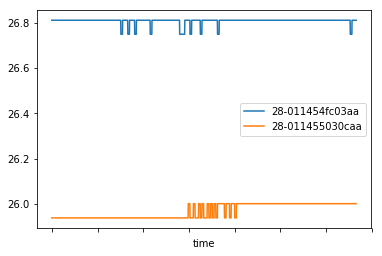

In [29]:
df.plot()